<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/optimization_practice/job_shop_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job shop Scheduling

* [Problem Statement][1]
* Minimizing the makespan
* Some jobs have to be scheduled in order
* No delay in each job

[1]:https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/04.03-Job-Shop-Scheduling.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

!python -m pip install gurobipy

from pyomo.environ import *
from pyomo.gdp import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 716.4 kB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 128208 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb ...
Unpacking coinor-libcgl1 (0.60.3+repack1-2) ...
Selecting previously unselect

In [8]:
def visualize(results):
    
    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = ['darkorange', 'deeppink', 'forestgreen', 'deepskyblue', 'darkorchid']

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(30, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%len(colors)], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%len(colors)], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

In [9]:
TASKS = {
    ('Paper_1','Blue')   : {'dur': 45, 'prec': None},
    ('Paper_1','Yellow') : {'dur': 10, 'prec': ('Paper_1','Blue')},
    ('Paper_2','Blue')   : {'dur': 20, 'prec': ('Paper_2','Green')},
    ('Paper_2','Green')  : {'dur': 10, 'prec': None},
    ('Paper_2','Yellow') : {'dur': 34, 'prec': ('Paper_2','Blue')},
    ('Paper_3','Blue')   : {'dur': 12, 'prec': ('Paper_3','Yellow')},
    ('Paper_3','Green')  : {'dur': 17, 'prec': ('Paper_3','Blue')},
    ('Paper_3','Yellow') : {'dur': 28, 'prec': None},   
}

In [10]:
def schedule_job_shop(TASKS):
  model = ConcreteModel()

  model.JM = Set(initialize=TASKS.keys(), dimen=2)
  model.J = Set(initialize=list(set(t[0] for t in TASKS.keys())))  # jobs
  model.M = Set(initialize=list(set(t[1] for t in TASKS.keys())))  # machines
  model.PAIRS = Set(initialize=model.JM * model.JM, dimen=4, filter=lambda model, j, m, k, n: TASKS[(j, m)]['prec'] == (k, n))
  model.DIST = Set(initialize=model.J * model.J * model.M, dimen=3, filter=lambda model, i, j, m: i < j and (i, m) in model.JM and (j, m) in model.JM)

  longest_process_time = sum([t['dur'] for t in TASKS.values()])
  model.makespan = Var(domain=NonNegativeReals, bounds=(0, longest_process_time))
  model.start = Var(model.JM, domain=NonNegativeReals, bounds=(0, longest_process_time))

  model.obj = Objective(expr=model.makespan, sense=minimize)

  # constraints
  model.c1 = Constraint(model.JM, rule=lambda model, j, m: model.start[j, m] + TASKS[j, m]['dur'] <= model.makespan)
  model.c2 = Constraint(model.PAIRS, rule=lambda model, j, m, k, n: model.start[k, n] + TASKS[k, n]['dur'] <= model.start[j, m])
  model.c3 = Disjunction(model.DIST, rule=lambda model, i, j, m: [model.start[i, m] + TASKS[i, m]['dur'] <= model.start[j, m],
                                                  model.start[j, m] + TASKS[j, m]['dur'] <= model.start[i, m]])

  TransformationFactory('gdp.hull').apply_to(model)
  SolverFactory('gurobi').solve(model).write()

  return model


def show_scheduled_results(TASKS):
  model = schedule_job_shop(TASKS)
  results = [{'Job': j,
              'Machine': m,
              'Start': model.start[j, m](), 
              'Duration': TASKS[j, m]['dur'], 
              'Finish': model.start[(j, m)]() + TASKS[j, m]['dur']}
              for j,m in model.JM]
            
  visualize(results)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x52
  Lower bound: 96.99999999999986
  Upper bound: 96.99999999999986
  Number of objectives: 1
  Number of constraints: 77
  Number of variables: 52
  Number of binary variables: 14
  Number of integer variables: 14
  Number of continuous variables: 38
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

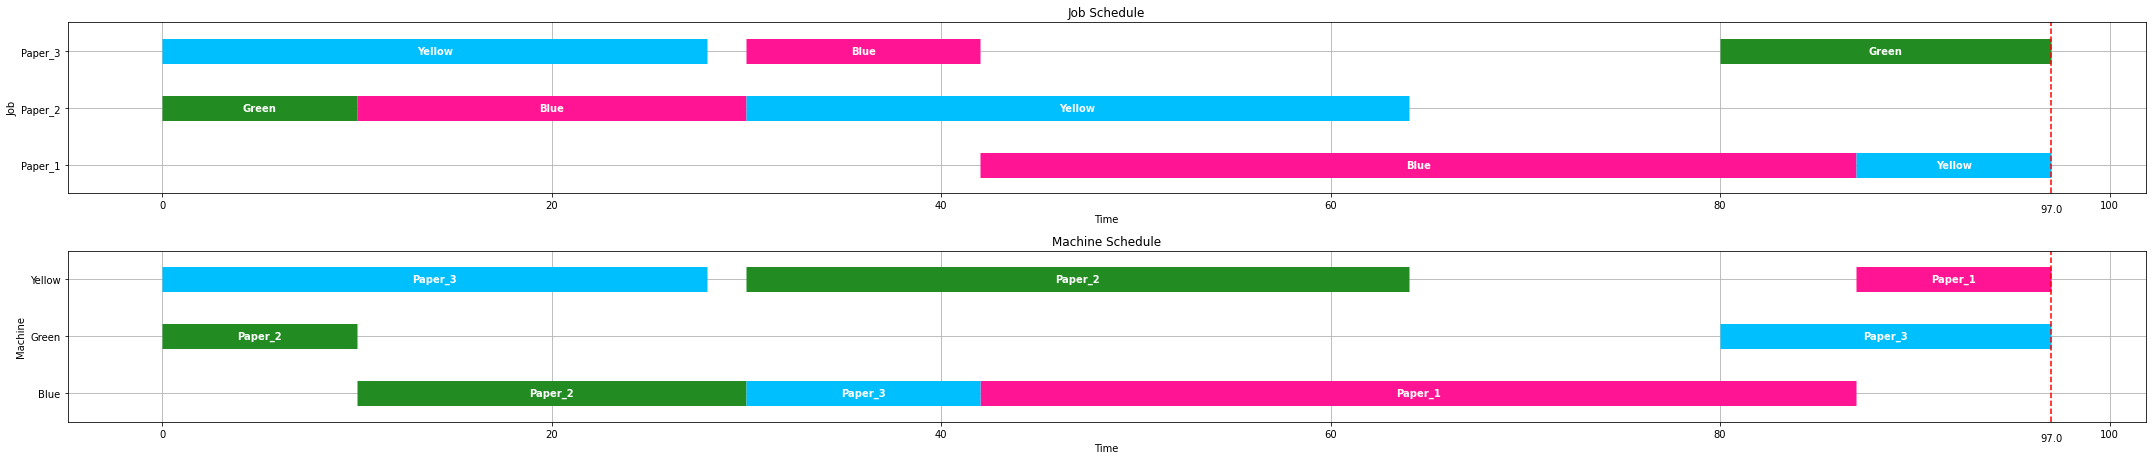

In [11]:
show_scheduled_results(TASKS)

## Single or Get Married

* Sometimes I'm really wondering whether getting married can save more efforts in daily life since when you're living alone you need to do all the housework while getting married can have someone to share the tasks. But married people have more housework to do. So, how about let's see the time spent on living alone vs getting married. 😎😉
* NOTE: set working hours as 3 hours here just to make the visualization easier to see

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x343
  Lower bound: 9.6
  Upper bound: 9.6
  Number of objectives: 1
  Number of constraints: 517
  Number of variables: 343
  Number of binary variables: 110
  Number of integer variables: 110
  Number of continuous variables: 233
  Number of nonzeros: 1253
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality 

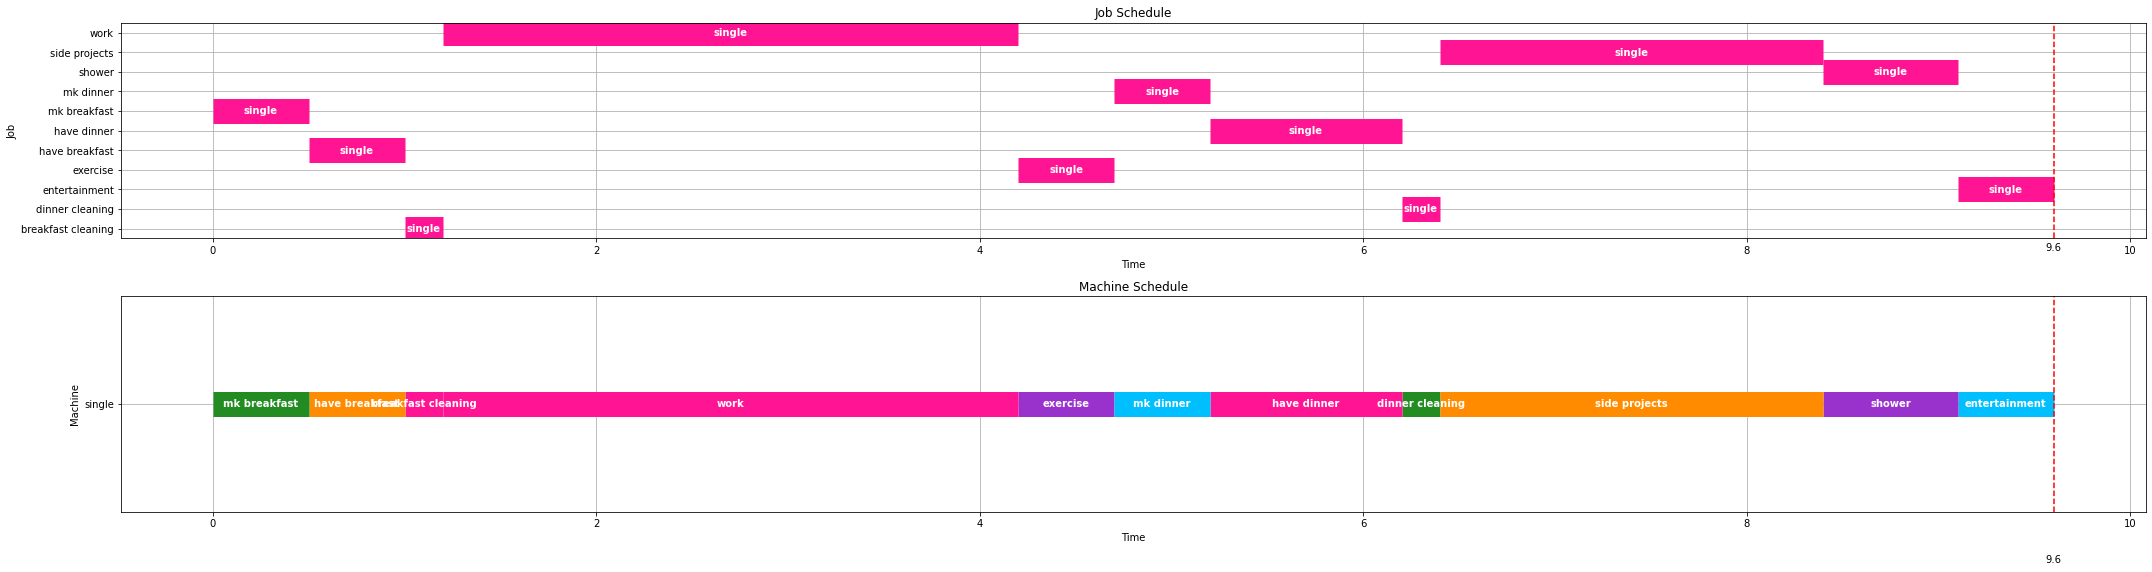

In [17]:
SINGLE_TASKS = {
    ('mk breakfast', 'single'): {'dur': 0.5, 'prec': None},
    ('have breakfast', 'single'): {'dur': 0.5, 'prec': ('mk breakfast', 'single')},
    ('breakfast cleaning', 'single'): {'dur': 0.2, 'prec': ('have breakfast', 'single')},
    ('work', 'single'): {'dur': 3, 'prec': ('breakfast cleaning', 'single')},
    ('exercise', 'single'): {'dur': 0.5, 'prec': ('work', 'single')},
    ('mk dinner', 'single'): {'dur': 0.5, 'prec': ('exercise', 'single')},
    ('have dinner', 'single'): {'dur': 1, 'prec': ('mk dinner', 'single')},
    ('dinner cleaning', 'single'): {'dur': 0.2, 'prec': ('have dinner', 'single')},
    ('side projects', 'single'): {'dur': 2, 'prec': ('dinner cleaning', 'single')},
    ('shower', 'single'): {'dur': 0.7, 'prec': ('side projects', 'single')},
    ('entertainment', 'single'): {'dur': 0.5, 'prec': ('shower', 'single')},
}
show_scheduled_results(SINGLE_TASKS)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x360
  Lower bound: 10.199999999999994
  Upper bound: 10.199999999999994
  Number of objectives: 1
  Number of constraints: 545
  Number of variables: 360
  Number of binary variables: 114
  Number of integer variables: 114
  Number of continuous variables: 246
  Number of nonzeros: 1317
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

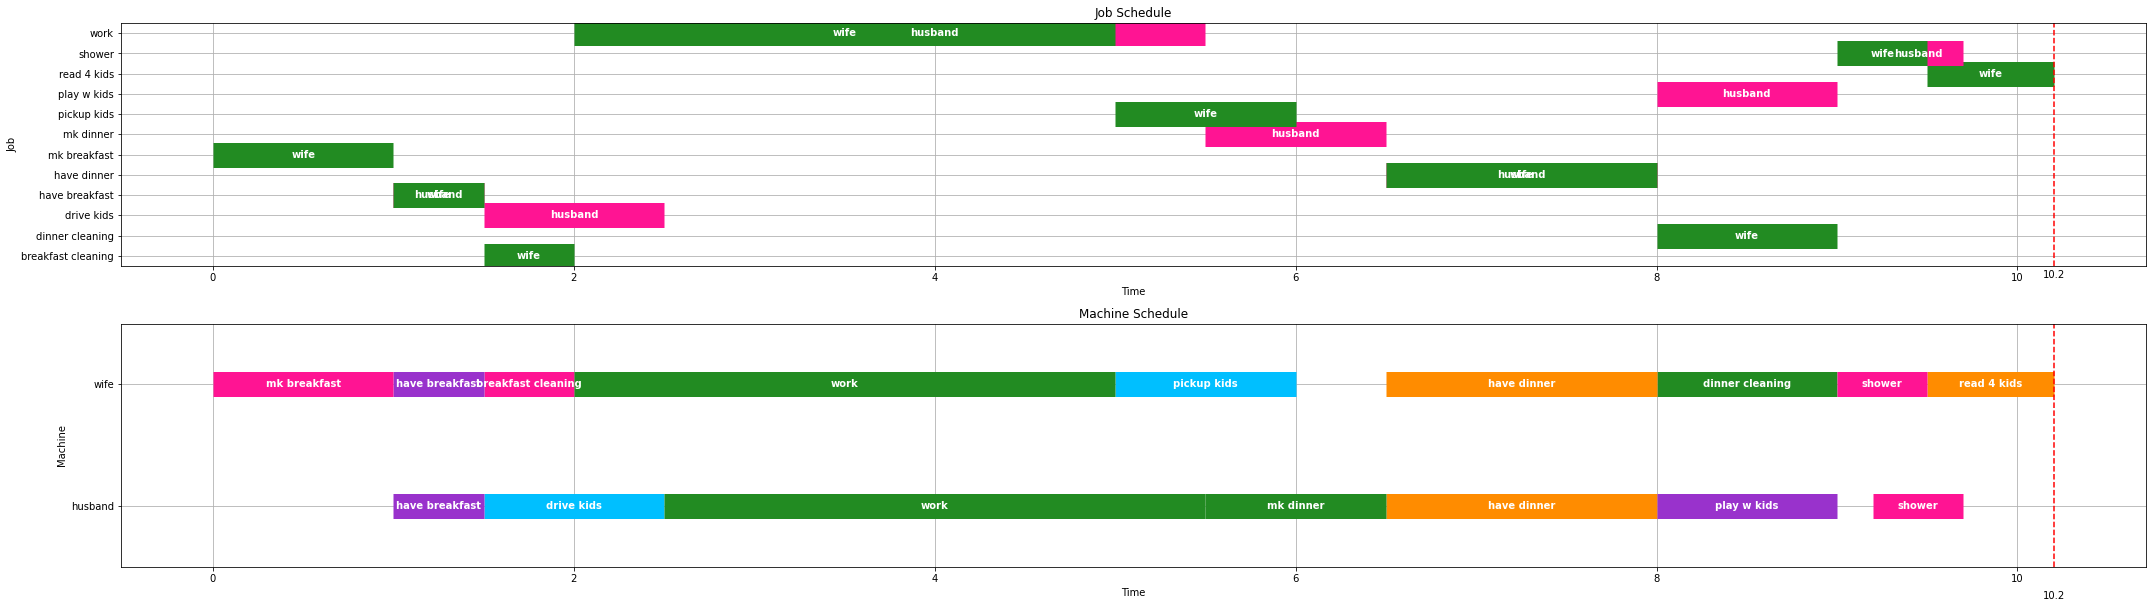

In [15]:
MARRIED_TASKS = {
    ('mk breakfast', 'wife'): {'dur': 1, 'prec': None},
    ('have breakfast', 'wife'): {'dur': 0.5, 'prec': ('mk breakfast', 'wife')},
    ('breakfast cleaning', 'wife'): {'dur': 0.5, 'prec': ('have breakfast', 'wife')},
    ('work', 'wife'): {'dur': 3, 'prec': ('breakfast cleaning', 'wife')},
    ('pickup kids', 'wife'): {'dur': 1, 'prec': ('work', 'wife')},
    ('have dinner', 'wife'): {'dur': 1.5, 'prec': ('pickup kids', 'wife')},
    ('have dinner', 'wife'): {'dur': 1.5, 'prec': ('mk dinner', 'husband')},
    ('dinner cleaning', 'wife'): {'dur': 1, 'prec': ('have dinner', 'wife')},
    ('shower', 'wife'): {'dur': 0.5, 'prec': ('dinner cleaning', 'wife')},
    ('read 4 kids', 'wife'): {'dur': 0.7, 'prec': ('play w kids', 'husband')},

    ('have breakfast', 'husband'): {'dur': 0.5, 'prec': ('mk breakfast', 'wife')},
    ('drive kids', 'husband'): {'dur': 1, 'prec': ('have breakfast', 'husband')},
    ('work', 'husband'): {'dur': 3, 'prec': ('drive kids', 'husband')},
    ('mk dinner', 'husband'): {'dur': 1, 'prec': ('work', 'husband')},
    ('have dinner', 'husband'): {'dur': 1.5, 'prec': ('mk dinner', 'husband')},
    ('have dinner', 'husband'): {'dur': 1.5, 'prec': ('pickup kids', 'wife')},
    ('play w kids', 'husband'): {'dur': 1, 'prec': ('have dinner', 'husband')},
    ('shower', 'husband'): {'dur': 0.5, 'prec': ('play w kids', 'husband')},
}
show_scheduled_results(MARRIED_TASKS)

🤔🤔 As we can see, after getting married, even after sacrificing side projects (learning) time and entertainment time, the total time we spend on family life is longer. This is already a super simplified version... Real world is much more complex, marriage is a complex stuff 🤔🤔